In [1]:
import torch
import torch.nn.utils.prune as prune
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import time
import psutil
import os
import copy
import torch.nn as nn
from torchvision.models.resnet import BasicBlock
from torch.ao.quantization.fake_quantize import FakeQuantize
from torch import Tensor
from typing import Any, Callable, List, Optional, Type, Union

# 1. Load pretrained ResNet-18
model = models.resnet18(pretrained=True)
model.eval()

# 4. Prepare a dummy input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img = Image.open("/Users/jjvyas1/Downloads/mla_project/n01443537_goldfish.JPEG").convert("RGB")  # replace with a real image path
input_tensor = transform(img).unsqueeze(0)  # batch dimension

/Users/jjvyas1/jinal_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jjvyas1/jinal_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
def evaluate(model, device_str='cuda'):
    global input_tensor
    input_tensor = input_tensor
    if not (device_str in['cpu', 'cuda']):
        raise NotImplementedError("`device_str` should be 'cpu' or 'cuda' ")
    if device_str == 'cuda':
        assert torch.cuda.is_available(), 'Check CUDA is available'
    input_batch = input_tensor.unsqueeze(0)[0]
    input_batch = input_batch.to(device_str)
    model.to(device_str)

    with torch.no_grad():
        output = model(input_batch)

    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    with open("/Users/jjvyas1/Downloads/mla_project/imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())

In [4]:
evaluate(model, 'cpu')

goldfish 0.8217602968215942
axolotl 0.14192184805870056
tench 0.01749112270772457
sturgeon 0.005148489493876696
puffer 0.004762660246342421


In [5]:
def get_model_size(model):
    torch.save(model.state_dict(), "temp.p")
    size_mb = os.path.getsize("temp.p") / 1e6
    os.remove("temp.p")
    print(f"Model size: {size_mb:.2f} MB")
    return size_mb


In [6]:
get_model_size(model)

Model size: 46.83 MB


46.828292

In [7]:
def measure_inference_time(model, input_size=(1, 3, 224, 224), device='cpu', repeats=50):
    model.eval()
    dummy_input = torch.randn(input_size).to(device)
    model.to(device)

    for _ in range(10):
        _ = model(dummy_input)

    start = time.time()
    for _ in range(repeats):
        _ = model(dummy_input)
    end = time.time()

    avg_time = (end - start) / repeats
    print(f"Inference time (avg over {repeats}): {avg_time*1000:.2f} ms")
    return avg_time

In [8]:
measure_inference_time(model)

Inference time (avg over 50): 17.49 ms


0.017494516372680666

In [9]:
import torch
from Downloads.mla_project.resnet import resnet18
# loading the quantized model
model = resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (add_relu_FF): FloatFunctional(
        (activation_post_process): Identity()
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e

In [10]:
modules_to_list = model.modules_to_fuse()
modules_to_list

[['conv1', 'bn1', 'relu'],
 ['layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu1'],
 ['layer1.0.conv2', 'layer1.0.bn2'],
 ['layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu1'],
 ['layer1.1.conv2', 'layer1.1.bn2'],
 ['layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu1'],
 ['layer2.0.conv2', 'layer2.0.bn2'],
 ['layer2.0.downsample.0', 'layer2.0.downsample.1'],
 ['layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu1'],
 ['layer2.1.conv2', 'layer2.1.bn2'],
 ['layer3.0.conv1', 'layer3.0.bn1', 'layer3.0.relu1'],
 ['layer3.0.conv2', 'layer3.0.bn2'],
 ['layer3.0.downsample.0', 'layer3.0.downsample.1'],
 ['layer3.1.conv1', 'layer3.1.bn1', 'layer3.1.relu1'],
 ['layer3.1.conv2', 'layer3.1.bn2'],
 ['layer4.0.conv1', 'layer4.0.bn1', 'layer4.0.relu1'],
 ['layer4.0.conv2', 'layer4.0.bn2'],
 ['layer4.0.downsample.0', 'layer4.0.downsample.1'],
 ['layer4.1.conv1', 'layer4.1.bn1', 'layer4.1.relu1'],
 ['layer4.1.conv2', 'layer4.1.bn2']]

In [11]:
model.eval()
fused_model = torch.ao.quantization.fuse_modules(model, modules_to_list)
fused_model

ResNet(
  (conv1): ConvReLU2d(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
  )
  (bn1): Identity()
  (relu): Identity()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (bn1): Identity()
      (relu1): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Identity()
      (add_relu_FF): FloatFunctional(
        (activation_post_process): Identity()
      )
    )
    (1): BasicBlock(
      (conv1): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (bn1): Identity()
      (relu1): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

In [12]:
from torch.ao.quantization.fake_quantize import FakeQuantize
activation_qconfig = FakeQuantize.with_args(
    observer=torch.ao.quantization.observer.HistogramObserver.with_args(
        quant_min=0,
        quant_max=255,
        dtype=torch.quint8,
        qscheme=torch.per_tensor_affine,
    )
)

weight_qconfig = FakeQuantize.with_args(
    observer=torch.ao.quantization.observer.PerChannelMinMaxObserver.with_args(
        quant_min=-128,
        quant_max=127,
        dtype=torch.qint8,
        qscheme=torch.per_channel_symmetric,
    )
)

qconfig = torch.quantization.QConfig(activation=activation_qconfig,
                                      weight=weight_qconfig)
fused_model.qconfig = qconfig

fused_model.train()
fake_quant_model = torch.ao.quantization.prepare_qat(fused_model)
fake_quant_model

ResNet(
  (conv1): ConvReLU2d(
    3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)
    (weight_fake_quant): FakeQuantize(
      fake_quant_enabled=tensor([1], dtype=torch.uint8), observer_enabled=tensor([1], dtype=torch.uint8), quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_channel_symmetric, ch_axis=0, scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32)
      (activation_post_process): PerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
    )
    (activation_post_process): FakeQuantize(
      fake_quant_enabled=tensor([1], dtype=torch.uint8), observer_enabled=tensor([1], dtype=torch.uint8), quant_min=0, quant_max=255, dtype=torch.quint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32)
      (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
    )
  )
  (bn1): Identity()
  (relu): Identity()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilat

In [13]:
print("\nFake quant - PTQ")
evaluate(fake_quant_model, 'cpu')

fake_quant_model.apply(torch.ao.quantization.fake_quantize.disable_observer)

print("\nFake quant - post-PTQ")
evaluate(fake_quant_model, 'cpu')


# Step 5: convert (true int8 model)
torch.backends.quantized.engine = 'qnnpack'
converted_model = torch.ao.quantization.convert(fake_quant_model)

print("\nConverted model")
evaluate(converted_model, 'cpu')


Fake quant - PTQ
goldfish 0.8090365529060364
axolotl 0.13504262268543243
tench 0.022541021928191185
sturgeon 0.00920926034450531
puffer 0.0070404428988695145

Fake quant - post-PTQ
goldfish 0.8090365529060364
axolotl 0.13504262268543243
tench 0.022541021928191185
sturgeon 0.00920926034450531
puffer 0.0070404428988695145

Converted model
goldfish 0.7802646160125732
axolotl 0.15577368438243866
tench 0.026001403108239174
sturgeon 0.011617783457040787
puffer 0.006790062412619591


In [14]:
converted_model

ResNet(
  (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.00305533641949296, zero_point=0, padding=(3, 3))
  (bn1): Identity()
  (relu): Identity()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.002219036454334855, zero_point=0, padding=(1, 1))
      (bn1): Identity()
      (relu1): Identity()
      (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.013336235657334328, zero_point=127, padding=(1, 1))
      (bn2): Identity()
      (add_relu_FF): QFunctional(
        scale=0.007735367398709059, zero_point=0
        (activation_post_process): Identity()
      )
    )
    (1): BasicBlock(
      (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.004394977353513241, zero_point=0, padding=(1, 1))
      (bn1): Identity()
      (relu1): Ident

In [15]:
import torch.nn as nn

class CustomDeQuantize(nn.Module):
    def forward(self, x):
        return x.dequantize() if x.is_quantized else x



In [16]:
# Step 1: Extract quantized FC layer and get its dequantized weight & bias
quant_fc = converted_model.fc
qweight, bias = quant_fc._weight_bias()

# Step 2: Dequantize the weights
dequant_weight = qweight.dequantize()
dequant_bias = bias

# Step 3: Replace QuantizedLinear with nn.Linear (float32)
fc_fp32 = nn.Linear(in_features=quant_fc.in_features,
                    out_features=quant_fc.out_features)

# Step 4: Assign dequantized weights and bias
fc_fp32.weight.data = dequant_weight
fc_fp32.bias.data = dequant_bias

# Step 5: Put it back into the model
# converted_model.fc = fc_fp32
converted_model.fc = nn.Sequential(
    CustomDeQuantize(),  # Manually defined
    fc_fp32
)


In [17]:
converted_model

ResNet(
  (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.00305533641949296, zero_point=0, padding=(3, 3))
  (bn1): Identity()
  (relu): Identity()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.002219036454334855, zero_point=0, padding=(1, 1))
      (bn1): Identity()
      (relu1): Identity()
      (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.013336235657334328, zero_point=127, padding=(1, 1))
      (bn2): Identity()
      (add_relu_FF): QFunctional(
        scale=0.007735367398709059, zero_point=0
        (activation_post_process): Identity()
      )
    )
    (1): BasicBlock(
      (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.004394977353513241, zero_point=0, padding=(1, 1))
      (bn1): Identity()
      (relu1): Ident

In [18]:
get_model_size(converted_model)

Model size: 13.35 MB


13.353194

In [19]:
measure_inference_time(model)

Inference time (avg over 50): 14.68 ms


0.014678578376770019

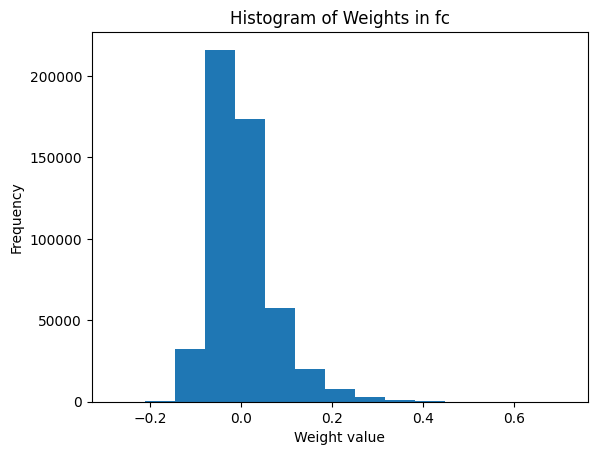

In [20]:
import matplotlib.pyplot as plt

for name, module in converted_model.named_modules():
    if name == "fc":
        weights = converted_model.fc[1].weight.detach().flatten().numpy()
        plt.hist(weights, bins=15)
        plt.title(f"Histogram of Weights in {name}")
        plt.xlabel("Weight value")
        plt.ylabel("Frequency")
        plt.show()

In [21]:
def custom_abs(flattened_weights, zero_point, scale):
  # Dequantize the weights
  dequantized_weights = scale * (flattened_weights.dequantize() - zero_point)

  # Calculate the absolute values
  absolute_flattened_weights = torch.abs(dequantized_weights)
  quantized_absolute_weights = torch.quantize_per_tensor(
    absolute_flattened_weights, scale, zero_point, torch.qint8)

  return quantized_absolute_weights

In [22]:
import torch.nn.utils.prune as prune
import numpy as np

for name, module in converted_model.named_modules():
  if "conv1" in name or "conv2" in name:
    print(module)
    weight = module.weight()
    scale = module.scale
    zero_point = module.zero_point

    # Perform pruning: Setting a fraction of weights to zero (e.g., 30%)
    pruning_amount = 0.3
    num_weights = weight.numel()
    num_pruned_weights = int(pruning_amount * num_weights)

    # Flatten the weights, sort by absolute value, and zero out the smallest
    zero_point = max(min(zero_point, 127), -128)
    weight = custom_abs(weight, zero_point, scale)
    flattened_weights = weight.reshape(-1)
    sorted_indices = torch.argsort(flattened_weights)

    # # Prune the smallest weights
    pruned_weights = flattened_weights.clone()
    pruned_weights[sorted_indices[:num_pruned_weights]] = 0

    # # Reshape pruned weights back to the original shape
    pruned_weights = pruned_weights.view_as(weight)

    # print(module.weight())
    # print(module.bias())
    bias = module.bias()
    module.set_weight_bias(pruned_weights, bias)

  if "fc" in name and isinstance(module, nn.Sequential):
    if isinstance(module[1], nn.Linear):
      prune.l1_unstructured(module[1], name="weight", amount=0.1)
      prune.remove(module[1], "weight")

QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.00305533641949296, zero_point=0, padding=(3, 3))
QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.002219036454334855, zero_point=0, padding=(1, 1))
QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.013336235657334328, zero_point=127, padding=(1, 1))
QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.004394977353513241, zero_point=0, padding=(1, 1))
QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.015967005863785744, zero_point=144, padding=(1, 1))
QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(2, 2), scale=0.005023206118494272, zero_point=0, padding=(1, 1))
QuantizedConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.017707210034132004, zero_point=90, padding=(1, 1))
QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.005754124838858843, zero_point=0, padding=(1, 1))
QuantizedConv2d(128, 128, kernel_siz

In [23]:
get_model_size(converted_model)

Model size: 13.28 MB


13.284244

In [24]:
measure_inference_time(model)

Inference time (avg over 50): 15.42 ms


0.015416641235351563

In [25]:
evaluate(converted_model, 'cpu')

washer 0.6157040596008301
syringe 0.3833581209182739
barrow 0.0004479032359085977
bucket 0.00015850670752115548
ashcan 7.864601502660662e-05


In [26]:
for name, module in converted_model.named_modules():
  print(name)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu1
layer1.0.conv2
layer1.0.bn2
layer1.0.add_relu_FF
layer1.0.add_relu_FF.activation_post_process
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu1
layer1.1.conv2
layer1.1.bn2
layer1.1.add_relu_FF
layer1.1.add_relu_FF.activation_post_process
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu1
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.0.add_relu_FF
layer2.0.add_relu_FF.activation_post_process
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu1
layer2.1.conv2
layer2.1.bn2
layer2.1.add_relu_FF
layer2.1.add_relu_FF.activation_post_process
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu1
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.0.add_relu_FF
layer3.0.add_relu_FF.activation_post_process
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu1
layer3.1.conv2
layer3.1.bn2
layer3.1.add_relu

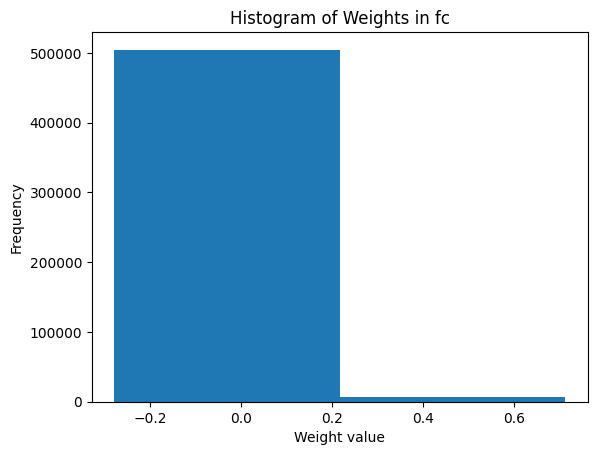

In [27]:
import matplotlib.pyplot as plt

for name, module in converted_model.named_modules():
    if name == "fc":
        weights = converted_model.fc[1].weight.detach().flatten().numpy()
        plt.hist(weights, bins=2)
        plt.title(f"Histogram of Weights in {name}")
        plt.xlabel("Weight value")
        plt.ylabel("Frequency")
        plt.show()
